In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook,tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Train

In [2]:
train_id = pd.read_csv("train_identity.csv")
train_tr = pd.read_csv("train_transaction.csv")

In [3]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [4]:
train_id.shape,train_tr.shape

((144233, 41), (590540, 394))

## Test

In [5]:
test_id = pd.read_csv('test_identity.csv')
test_tr = pd.read_csv('test_transaction.csv')

In [6]:
test_id.shape,test_tr.shape

((141907, 41), (506691, 393))

## merging identity and transaction

In [7]:
train = pd.merge(train_tr,train_id,on='TransactionID',how=
            'left')
test = pd.merge(test_tr,test_id,on='TransactionID',how='left')

del train_id,train_tr,test_id,test_tr

gc.collect() # garbage collector

11

In [8]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,vis

## Negative Downsampling

In [9]:
train_pos = train[train['isFraud']==1]
train_neg = train[train['isFraud']==0]

train_neg = train_neg.sample(10*int(train_pos.shape[0] ), random_state=42)
train = pd.concat([train_pos,train_neg]).sort_index()

In [10]:
train_pos.shape,train_neg.shape

((20663, 434), (206630, 434))

In [11]:
train.isna().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               3534
card3                581
card4                585
card5               1693
card6                583
addr1              28879
addr2              28879
dist1             138047
dist2             211218
P_emaildomain      35903
R_emaildomain     170097
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                   521
D2                109978
D3                102622
D4                 65134
D5                118791
D6                195741
D7                209529
D8                195014
D9                195014


In [12]:
train = train.sort_values('TransactionDT')

In [13]:
train.shape

(227293, 434)

In [14]:
train.drop_duplicates(inplace=True)

In [15]:
train.shape

(227293, 434)

In [16]:
target = train["isFraud"]
train.drop(["isFraud"], axis=1, inplace=True)

In [17]:
useful_features = [col for col in train.columns]

In [18]:
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

### card feature

In [19]:
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)

train['uid1'] = train['uid'].astype(str)+'_'+train['card3'].astype(str)
test['uid1'] = test['uid'].astype(str)+'_'+test['card3'].astype(str)


train['uid2'] = train['uid'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['uid3'] = train['uid2'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

train['uid4'] = train['card4'].astype(str)+'_'+train['card6'].astype(str)
test['uid4'] = test['card4'].astype(str)+'_'+test['card6'].astype(str)

train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

### id features

In [20]:
train['id'] = train['id_35'].astype(str)+'_'+train['id_36'].astype(str)
test['id'] = test['id_35'].astype(str)+'_'+test['id_36'].astype(str)

train['id1'] = train['id'].astype(str)+'_'+train['id_37'].astype(str)
test['id1'] = test['id'].astype(str)+'_'+test['id_37'].astype(str)


train['id2'] = train['id1'].astype(str)+'_'+train['id_38'].astype(str)
test['id2'] = test['id1'].astype(str)+'_'+test['id_38'].astype(str)

In [21]:
train = pd.concat([train,test])

In [22]:
del test
gc.collect()

0

In [23]:
train.drop(["TransactionID", "TransactionDT"], axis=1, inplace=True)
train.shape

(733984, 442)

In [24]:
neglect = ["TransactionAmt", 'Transaction_day_of_week', 'Transaction_hour']

In [25]:
train['M_na'] = abs(train.isna().sum(axis=1).astype(np.int8))

In [26]:
non_nan = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
          "D1", "M_na"]

In [27]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    
    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = 'Others'
    gc.collect()
    return dataframe

In [28]:
train = id_split(train)

In [29]:
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)

In [30]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 
          'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 
          'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 
          'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 
          'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 
          'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 
          'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 
          'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 
          'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 
          'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [31]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [32]:
useful_features = [col for col in train.columns if col not in neglect]

In [33]:
i=0        
for feature in useful_features:
    
        # Count encoded separately for train and test
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    if feature not in non_nan:
        train.drop([feature], axis=1,inplace=True)
    print("Done" + str(i))
    i+=1

Done0
Done1
Done2
Done3
Done4
Done5
Done6
Done7
Done8
Done9
Done10
Done11
Done12
Done13
Done14
Done15
Done16
Done17
Done18
Done19
Done20
Done21
Done22
Done23
Done24
Done25
Done26
Done27
Done28
Done29
Done30
Done31
Done32
Done33
Done34
Done35
Done36
Done37
Done38
Done39
Done40
Done41
Done42
Done43
Done44
Done45
Done46
Done47
Done48
Done49
Done50
Done51
Done52
Done53
Done54
Done55
Done56
Done57
Done58
Done59
Done60
Done61
Done62
Done63
Done64
Done65
Done66
Done67
Done68
Done69
Done70
Done71
Done72
Done73
Done74
Done75
Done76
Done77
Done78
Done79
Done80
Done81
Done82
Done83
Done84
Done85
Done86
Done87
Done88
Done89
Done90
Done91
Done92
Done93
Done94
Done95
Done96
Done97
Done98
Done99
Done100
Done101
Done102
Done103
Done104
Done105
Done106
Done107
Done108
Done109
Done110
Done111
Done112
Done113
Done114
Done115
Done116
Done117
Done118
Done119
Done120
Done121
Done122
Done123
Done124
Done125
Done126
Done127
Done128
Done129
Done130
Done131
Done132
Done133
Done134
Done135
Done136
Done137
Done13

In [34]:
dropping =["D8_count_dist", "V138_count_dist", "V139_count_dist", "V140_count_dist", "V141_count_dist",\
           "V146_count_dist", "V147_count_dist", "V148_count_dist", "V149_count_dist", "V144_count_dist",\
           "V145_count_dist", "V150_count_dist", "V151_count_dist", "V152_count_dist", "V153_count_dist",\
           "V154_count_dist", "V155_count_dist", "V156_count_dist", "V157_count_dist", "V158_count_dist",\
           "V159_count_dist", "V160_count_dist", "V161_count_dist", "V162_count_dist", "V163_count_dist",\
           "V164_count_dist", "V165_count_dist", "V166_count_dist", "V168_count_dist", "V170_count_dist",\
           "V171_count_dist", "V172_count_dist", "V173_count_dist", "V174_count_dist", "V175_count_dist",\
           "V176_count_dist", "V177_count_dist", "V178_count_dist", "V179_count_dist", "V180_count_dist",\
           "V181_count_dist", "V182_count_dist", "V183_count_dist", "V184_count_dist", "V185_count_dist",\
           "V186_count_dist", "V187_count_dist", "V188_count_dist", "V189_count_dist", "V190_count_dist",\
           "V191_count_dist", "V192_count_dist", "V193_count_dist", "V194_count_dist", "V195_count_dist",\
           "V196_count_dist", "V197_count_dist", "V198_count_dist", "V199_count_dist", "V200_count_dist",\
           "V201_count_dist", "V202_count_dist", "V203_count_dist", "V204_count_dist", "V205_count_dist",\
           "V206_count_dist", "V207_count_dist", "V208_count_dist", "V209_count_dist", "V210_count_dist",\
           "V211_count_dist", "V212_count_dist", "V213_count_dist", "V214_count_dist", "V215_count_dist",\
           "V216_count_dist", "V218_count_dist", "V219_count_dist", "V221_count_dist", "V222_count_dist",\
           "V223_count_dist", "V224_count_dist", "V225_count_dist", "V226_count_dist", "V227_count_dist",\
           "V228_count_dist", "V229_count_dist", "V230_count_dist", "V231_count_dist", "V232_count_dist",\
           "V233_count_dist", "V234_count_dist", "V235_count_dist", "V236_count_dist", "V237_count_dist",\
           "V205_count_dist", "V205_count_dist", "V205_count_dist", "V205_count_dist", "V205_count_dist",\
           "V238_count_dist", "V239_count_dist", "V240_count_dist", "V241_count_dist", "V242_count_dist",\
           "V243_count_dist", "V244_count_dist", "V245_count_dist","V246_count_dist", "V247_count_dist",\
           "V248_count_dist", "V249_count_dist", "V250_count_dist", "V251_count_dist", "V252_count_dist",\
           "V253_count_dist", "V254_count_dist", "V255_count_dist", "V256_count_dist", "V257_count_dist",\
           "V258_count_dist", "V259_count_dist", "V260_count_dist", "V261_count_dist", "V262_count_dist",\
           "V263_count_dist", "V264_count_dist", "V265_count_dist", "V266_count_dist", "V267_count_dist",\
           "V268_count_dist", "V269_count_dist", "V270_count_dist", "V271_count_dist", "V272_count_dist",\
           "V273_count_dist", "V274_count_dist", "V275_count_dist", "V276_count_dist", "V277_count_dist",\
           "V278_count_dist", "V323_count_dist", "V324_count_dist", "V325_count_dist", "V326_count_dist",\
           "V327_count_dist", "V328_count_dist", "V329_count_dist", "V330_count_dist", "V331_count_dist",\
           "V332_count_dist", "V333_count_dist", "V334_count_dist", "V335_count_dist", "V336_count_dist",\
           "V237_count_dist", "V238_count_dist", "V239_count_dist", "id_04_count_dist", "id_06_count_dist",\
           "id_08_count_dist", "id_10_count_dist", "id_22_count_dist", "id_27_count_dist", "id_29_count_dist",\
           "id_36_count_dist", "id_37_count_dist", "id_38_count_dist"]

In [35]:
train = train.drop(dropping, axis=1)

In [36]:
train['feat1'] = (train["TransactionAmt"]/train['uid_count_dist'])*100
train['feat2'] = (train["TransactionAmt"]/train['uid3_count_dist'])*100
train['feat3'] = (train["TransactionAmt"]/train['card1_count_dist'])*100

In [37]:
train.isna().sum()

TransactionAmt                            0
C1                                        3
C2                                        3
C3                                        3
C4                                        3
C5                                        3
C6                                        3
C7                                        3
C8                                        3
C9                                        3
C10                                       3
C11                                       3
C12                                       3
C13                                    4748
C14                                       3
D1                                     6552
Transaction_day_of_week                   0
Transaction_hour                          0
M_na                                      0
ProductCD_count_dist                      0
card1_count_dist                          0
card2_count_dist                          0
card3_count_dist                

In [38]:
train.fillna(-1, inplace=True)

#### seperating test from train

In [39]:
l = 11*int(train_pos.shape[0])

In [40]:
X = train.iloc[:l, :]
test = train.iloc[l:, :]

In [41]:
y=target

In [73]:
print(X.iloc[:,0:100].columns)
print(X.iloc[:,100:200].columns)
print(X.iloc[:,200:300].columns)
print(X.iloc[:,300:].columns)

Index(['TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'Transaction_day_of_week',
       'Transaction_hour', 'M_na', 'ProductCD_count_dist', 'card1_count_dist',
       'card2_count_dist', 'card3_count_dist', 'card4_count_dist',
       'card5_count_dist', 'card6_count_dist', 'addr1_count_dist',
       'addr2_count_dist', 'dist1_count_dist', 'dist2_count_dist',
       'P_emaildomain_count_dist', 'R_emaildomain_count_dist', 'C1_count_dist',
       'C2_count_dist', 'C3_count_dist', 'C4_count_dist', 'C5_count_dist',
       'C6_count_dist', 'C7_count_dist', 'C8_count_dist', 'C9_count_dist',
       'C10_count_dist', 'C11_count_dist', 'C12_count_dist', 'C13_count_dist',
       'C14_count_dist', 'D1_count_dist', 'D2_count_dist', 'D3_count_dist',
       'D4_count_dist', 'D5_count_dist', 'D6_count_dist', 'D7_count_dist',
       'D9_count_dist', 'D10_count_dist', 'D11_count_dist', 'D12_count_dist',
       'D13_count_dist', 'D1

In [62]:
X['card1_count_dist_mean_diff'] = X['card1_count_dist'] - X['card1_count_dist'].mean()
X['card2_count_dist_mean_diff'] = X['card2_count_dist'] - X['card2_count_dist'].mean()
X['card3_count_dist_mean_diff'] = X['card3_count_dist'] - X['card3_count_dist'].mean()
X['card4_count_dist_mean_diff'] = X['card4_count_dist'] - X['card4_count_dist'].mean()
X['card5_count_dist_mean_diff'] = X['card5_count_dist'] - X['card5_count_dist'].mean()
X['card6_count_dist_mean_diff'] = X['card6_count_dist'] - X['card6_count_dist'].mean()


In [64]:
test['card1_count_dist_mean_diff'] = test['card1_count_dist'] - test['card1_count_dist'].mean()
test['card2_count_dist_mean_diff'] = test['card2_count_dist'] - test['card2_count_dist'].mean()
test['card3_count_dist_mean_diff'] = test['card3_count_dist'] - test['card3_count_dist'].mean()
test['card4_count_dist_mean_diff'] = test['card4_count_dist'] - test['card4_count_dist'].mean()
test['card5_count_dist_mean_diff'] = test['card5_count_dist'] - test['card5_count_dist'].mean()
test['card6_count_dist_mean_diff'] = test['card6_count_dist'] - test['card6_count_dist'].mean()


In [65]:
test.shape

(506691, 322)

In [45]:
np.save('X.npy',X)
np.save('test.npy',test)


np.save('y.npy',y)

In [67]:
from catboost import CatBoostRegressor
categorical_var = np.where(train.dtypes != np.float)[0]
print('\nCategorical Variables indices : ',categorical_var)


Categorical Variables indices :  [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 

In [3]:
X = np.load('X.npy')
X.shape

(227293, 316)

In [4]:
test = np.load('test.npy')
y = np.load('y.npy')
print(test.shape)
print(y.shape)

(506691, 316)
(227293,)


In [66]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          "n_jobs" : -1
         }

In [68]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999772	valid_1's auc: 0.899059
Early stopping, best iteration is:
[1342]	training's auc: 0.999991	valid_1's auc: 0.899793
Fold 1 finished in 0:00:49.178264
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999657	valid_1's auc: 0.922436
Early stopping, best iteration is:
[986]	training's auc: 0.999623	valid_1's auc: 0.922474
Fold 2 finished in 0:01:21.688893
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999432	valid_1's auc: 0.917568
Early stopping, best iteration is:
[1058]	training's auc: 0.999602	valid_1's auc: 0.917684
Fold 3 finished in 0:02:10.998842
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998316	valid_1's auc: 0.934914
[2000]	training's auc: 0.999995	valid_1's auc: 0.936158
[3000]	training's 

In [24]:
import xgboost as xgb
xgb.train()

In [47]:
params = {'num_leaves': 491,
         'min_data_in_leaf': 10, 
         'objective':'binary:logistic',
         'max_depth': 1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         'min_child_weight': 0.03454472573214212,
        'feature_fraction': 0.3797454081646243,
        'bagging_fraction': 0.4181193142567742,
         "bagging_freq": 1,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": 1,
         "nthread": -1,
         "random_state": 42}

In [50]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
# feature_importances = pd.DataFrame()
# feature_importances['feature'] = X.columns

training_start_time = time()
sub_preds = np.zeros(test.shape[0])
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    X_tr, Y_tr = X[trn_idx], y[trn_idx]
    X_val,Y_val = X[test_idx],y[test_idx]
    clf = xgb.XGBClassifier(**params,n_estimators = 20000,n_jobs = -1)
    clf.fit(X_tr,Y_tr,
             eval_set=[(X_tr,Y_tr),(X_val,Y_val)],
             eval_metric = 'auc',
             verbose = 1000,
             early_stopping_rounds=500)
#     feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
    sub_preds += clf.predict_proba(test)[:, 1] / folds.n_splits
    
    aucs.append(roc_auc_score(Y_val,clf.predict_proba(X_val)[:,1]/folds.n_splits))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
[0]	validation_0-auc:0.610149	validation_1-auc:0.581058
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[1000]	validation_0-auc:0.746604	validation_1-auc:0.736006
[2000]	validation_0-auc:0.816693	validation_1-auc:0.801897
[3000]	validation_0-auc:0.827571	validation_1-auc:0.808755
[4000]	validation_0-auc:0.831917	validation_1-auc:0.811806
[5000]	validation_0-auc:0.836054	validation_1-auc:0.817867
[6000]	validation_0-auc:0.843024	validation_1-auc:0.824413
[7000]	validation_0-auc:0.846394	validation_1-auc:0.829654
[8000]	validation_0-auc:0.850574	validation_1-auc:0.833897
[9000]	validation_0-auc:0.85368	validation_1-auc:0.836756
[10000]	validation_0-auc:0.856078	validation_1-auc:0.839107
[11000]	validation_0-auc:0.858195	validation_1-auc:0.840914
[12000]	validation_0-auc:0.860109	validation_1-auc:0.84255
[13000]	validation_0-auc:0.862005	validation_1-auc:0.84405

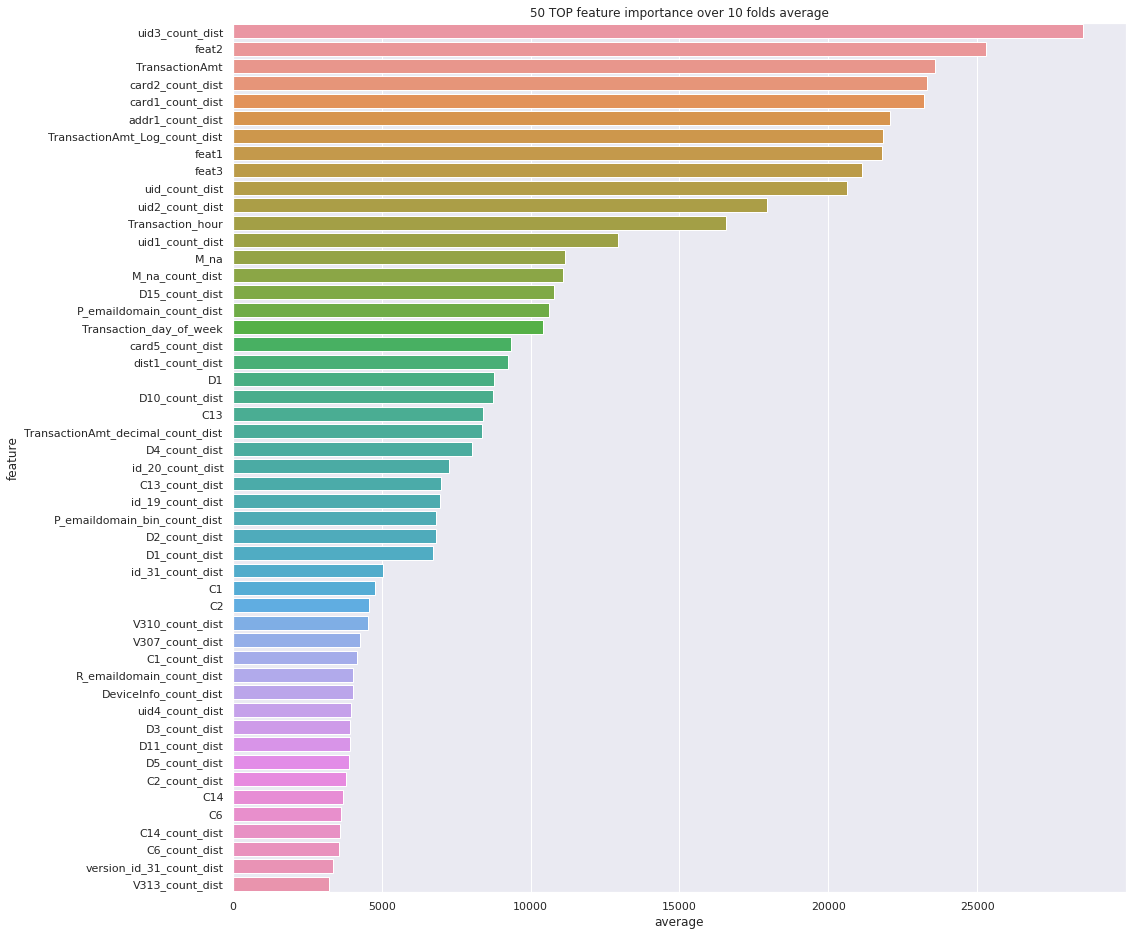

In [58]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [69]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration

## Submission

In [70]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=2357, num_leaves=491,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [71]:
sub = pd.read_csv("sample_submission.csv")

In [31]:
sub['isFraud'] = sub_preds

In [32]:
sub.to_csv('csv/trail_4.csv', index=False)

In [55]:
X.shape

(227293, 316)

In [33]:
!kaggle competitions submit -c ieee-fraud-detection -f csv/trail_4.csv -m "Trail-4"

100%|██████████████████████████████████████| 13.9M/13.9M [00:05<00:00, 2.78MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [36]:
trail_3 = pd.read_csv('csv/trail_3.csv')

341763

In [37]:
sub['isFraud'] = (trail_3['isFraud'] + sub_preds)/2
sub.to_csv('csv/trail_5.csv', index=False)

In [38]:
sub['isFraud'].shape

(506691,)

In [39]:
!kaggle competitions submit -c ieee-fraud-detection -f csv/trail_8.csv -m "Trail-8"

100%|██████████████████████████████████████| 13.9M/13.9M [00:04<00:00, 3.18MB/s]
Successfully submitted to IEEE-CIS Fraud Detection